#OTOKODLAYICILAR

GPU'da Çalışma

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


Kütüphane Kurulumu

In [16]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.callbacks import TensorBoard #Eğitim yağtığımızda ekrana yazdırıcak şey.
from keras.datasets import mnist
import numpy as np
from keras import backend as K
import matplotlib.pyplot as plt

Veri Kümesini Oluşturmak Ve Ayırmak

In [17]:
(x_train, _), (x_test, _) = mnist.load_data()

In [18]:
x_train = x_train.astype("float32")/ 255 #Normalizasyon olması için 255 e böldük.
x_test = x_test.astype("float32")/ 255 

#Reshape işlemi
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))#channel first
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [19]:
print('Eğitim: ', x_train.shape)
print('Test: ', x_test.shape)

Eğitim:  (60000, 28, 28, 1)
Test:  (10000, 28, 28, 1)


Veriye Gürültü Ekleme Adımı

In [20]:
#Amacımız otokodlayıcıyı kullanarak önce gürültülü görüntüden bottleneck ten daha donra decode yapaken(upsamplingg)
#kısmını yükseltme kısmını yaparken aslında görntünün öznşteliklerine ait bazı özellikler kaybolur.
#En baştaki kadar iyi bir sonuç almayabiliriz. Aldığımız durumlarda var bazı yaklaşımlarla
#Gürültünün gitmesinin en önemli sebebi bu olmuş olacak.

noise_factor = 0.5

#Normal dağılımla bunu yayıyoruz.
x_train_noisy = x_train + noise_factor * np.random.normal(loc = 0.0, scale = 1.0, size = x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc = 0.0, scale = 1.0, size = x_test.shape)

#Bu şekilde gürültülü setler elde etmiş olduk.
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Gürültülü Veriyi Görselleştirme

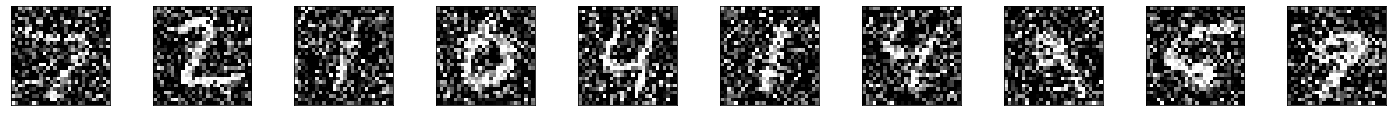

Gürültülü Orjinal Görüntüler


In [21]:
#Orjinal görüntümüz gürültülü halleri olmuş oldu çünkü gürültüden bastırmaya çalışıcaz. Gürültüyü arındırmaya çalışıcaz. O ise işlemiş hali olacak görüntülein.

%matplotlib inline

n = 10

plt.figure(figsize= (25 ,4))

for i in range(n):
   ax = plt.subplot(2, n, i+1)
   plt.imshow(x_test_noisy[i].reshape(28, 28))#28 28 orjinal g
   plt.gray()
   ax.get_xaxis().set_visible(False)#Görüntünün x ve y değerlerini yazmasın direk görüntüyü görelim diye yaptık.
   ax.get_yaxis().set_visible(False)
plt.show()
print('Gürültülü Orjinal Görüntüler')   

##ENCODE Modeli

In [22]:
input_img = Input(shape = (28, 28, 1))#channel first şeklinde ayarladık.

x = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(input_img)#32 nöron var. (3,3) filtre boyutu

x = MaxPooling2D((2, 2), padding = 'same')(x)

x = Conv2D(32, (3,3), activation = 'relu', padding ='same')(x)

# Dar boğaz burası olacak.
encoded = MaxPooling2D((2,2), padding = 'same')(x)

#(7, 7, 32) işlemi elde etmiş olmamız lazım.(28, 28, 1)i bu boyutlara getirmiş olduk.

##DECODE Modeli

In [23]:
#Şimdi darboğazdan çıkıp arttırma işlemini yapıyoruz.
x = Conv2D(32, (3,3), activation='relu', padding = 'same')(encoded)

#Upsampling büyütme işlemini gerçeekleştirmiş oluyor. Pikseller arasında smooth işlemi yapmış oluyor.
x = UpSampling2D((2, 2))(x)

x = Conv2D(32, (3,3), activation='relu', padding = 'same')(x)

x = UpSampling2D((2, 2))(x)


decoded = Conv2D(1, (3, 3), activation= 'sigmoid', padding = 'same')(x)#1 kanallı (3,3) lük filtre uyguladık.
#yeni görüntüm decoded edilen görüntü olmuş oldu.

Modelin Derlenmesi ve Eğitilmesi

In [24]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [25]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

decoded_imgs = autoencoder.predict(x_test)

Epoch 1/100
469/469 [==============================] - 3s 7ms/step - loss: 0.6803 - val_loss: 0.6733
Epoch 2/100
469/469 [==============================] - 3s 7ms/step - loss: 0.6595 - val_loss: 0.6407
Epoch 3/100
469/469 [==============================] - 3s 7ms/step - loss: 0.6044 - val_loss: 0.5611
Epoch 4/100
469/469 [==============================] - 3s 7ms/step - loss: 0.5245 - val_loss: 0.5074
Epoch 5/100
469/469 [==============================] - 3s 7ms/step - loss: 0.4992 - val_loss: 0.4989
Epoch 6/100
469/469 [==============================] - 3s 6ms/step - loss: 0.4919 - val_loss: 0.4920
Epoch 7/100
469/469 [==============================] - 3s 7ms/step - loss: 0.4849 - val_loss: 0.4846
Epoch 8/100
469/469 [==============================] - 3s 7ms/step - loss: 0.4772 - val_loss: 0.4765
Epoch 9/100
469/469 [==============================] - 3s 7ms/step - loss: 0.4686 - val_loss: 0.4672
Epoch 10/100
469/469 [==============================] - 3s 6ms/step - loss: 0.4587 - val_lo

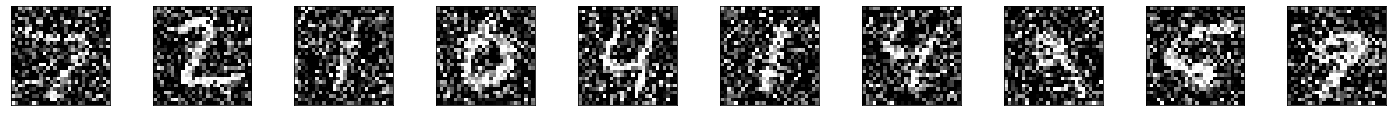

DENOISED - GÜRÜLTÜSÜ BASTIRILMIŞ GÖRÜNTÜ


In [26]:
%matplotlib inline

n = 10

plt.figure(figsize= (25 ,4))

for i in range(n):
   ax = plt.subplot(2, n, i+1)
   plt.imshow(x_test_noisy[i].reshape(28, 28))#28 28 orjinal g
   plt.gray()
   ax.get_xaxis().set_visible(False)#Görüntünün x ve y değerlerini yazmasın direk görüntüyü görelim diye yaptık.
   ax.get_yaxis().set_visible(False)
plt.show()
print('DENOISED - GÜRÜLTÜSÜ BASTIRILMIŞ GÖRÜNTÜ')   